# Problem 3

In this part, we compare two generative models, the W-GAN-GP model and the VAE model.

In [0]:
# Mount the virtual drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My\ Drive/Colab\ Notebooks/AaronTP3

/content/gdrive/My Drive/Colab Notebooks/AaronTP3


In [0]:
# Libraries

import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch import nn
from torch.autograd import Variable

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import numpy as np

import scipy.io as io

## Dataloader

In [0]:
transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])

class SVHNDataset(Dataset):
    def __init__(self, mat_path,transform=None):
        self.path = mat_path
        self.images = None
        self.targets = None
        self.transform = transform
    
    def uploadData(self):
        data = io.loadmat(self.path)
        self.images = torch.from_numpy(data['X'])
        self.targets = torch.from_numpy(data['y'])
      
    def __getitem__(self, index):
        image_tensor = self.images.permute(3,2,0,1)[index].float()/255.
        target_tensor = self.targets[index]
        if self.transform:
           image_tensor = self.transform(image_tensor)
        return image_tensor, target_tensor

    def __len__(self):
        return len(self.targets)



In [0]:
torch.manual_seed(123)

def get_data_loader(batch_size=1, num_workers=1, shuffle=True):

    trainpath = "data_svhn/train_32x32.mat"
    testpath = "data_svhn/test_32x32.mat"
    
    dataset = SVHNDataset(trainpath)
    dataset.uploadData()
    
    
    testset = SVHNDataset(testpath)
    testset.uploadData()

    
    trainloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )

    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
    )

    return trainloader, testloader

batch_size = 32
trainloader, testloader = get_data_loader(batch_size=batch_size, num_workers=2)

Let us see what an input can look like:

A data sample from the dataset:


(-0.5, 31.5, 31.5, -0.5)

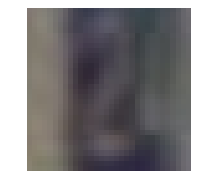

In [0]:
plt.rcParams["figure.figsize"] = [3,3]

tensor_image = next(iter(trainloader))[0][0]

print("A data sample from the dataset:")
plt.imshow(tensor_image.transpose(0,2).transpose(0,1))

plt.axis("off")

Blurry...

# Training Models

In [0]:
from torchsummary import summary
# For GPU use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## VAE

In this section, the VAE that we implement is similar to the one implemented in Problem 2, except that the input has a different size, is real valued, and has 3 channels. The encoder/decoder has been adapted to this setting.

In [0]:
# VAE model
class VAE(nn.Module):
  
    def __init__(self):
      
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
          nn.ELU(), # amortized ReLU
          nn.AvgPool2d(kernel_size=2, stride=2),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4),
          nn.ELU(),
          nn.AvgPool2d(kernel_size=2, stride=2), 
          nn.Conv2d(in_channels=64, out_channels=256, kernel_size=6),
          nn.ELU()
        )

        # Bottleneck
        self.fcEncoder = nn.Linear(in_features=256, out_features=200) # outputs mu and sigma

        # Decoder
        self.decoder = self.main_module = nn.Sequential(
          nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0),
          nn.BatchNorm2d(num_features=512),
          nn.ReLU(True),

          nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(num_features=256),
          nn.ReLU(True),

          nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(num_features=128),
          nn.ReLU(True),

          nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1)
        )

        # Apply activation function on the output
        self.activation = nn.Sigmoid()

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), 256)
        q_params = self.fcEncoder(x) # Size 200
        mu, logvar = q_params[:, :100] , q_params[:, 100:] # Mean & log(Variance)
        return mu, logvar

    def sample_latent(self, mu, logvar):
        # reparametrization trick:
        e = torch.randn(mu.size(0), 100).to(device) # Random samples from the N(0,1) distribution
        z = mu + e * logvar.mul(0.5).exp()
        return z

    def decode(self, z):
        x_hat = z.view(z.size(0), -1, 1, 1)
        return self.activation(self.decoder(x_hat)) # Apply tanh on the output

    def forward(self, x):
        mu, log_var = self.encode(x) # encode to compute mean and log variance
        z = self.sample_latent(mu, log_var) # sample a latent variable from mean and log variance
        return self.decode(z), mu, log_var # decode latent variable
      
vae = VAE().to(device)

summary(vae,input_size=(3, 32, 32),batch_size=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [5, 32, 30, 30]             896
               ELU-2            [5, 32, 30, 30]               0
         AvgPool2d-3            [5, 32, 15, 15]               0
            Conv2d-4            [5, 64, 12, 12]          32,832
               ELU-5            [5, 64, 12, 12]               0
         AvgPool2d-6              [5, 64, 6, 6]               0
            Conv2d-7             [5, 256, 1, 1]         590,080
               ELU-8             [5, 256, 1, 1]               0
            Linear-9                   [5, 200]          51,400
  ConvTranspose2d-10             [5, 512, 4, 4]         819,712
      BatchNorm2d-11             [5, 512, 4, 4]           1,024
             ReLU-12             [5, 512, 4, 4]               0
  ConvTranspose2d-13             [5, 256, 8, 8]       2,097,408
      BatchNorm2d-14             [5, 25

In [0]:
class VAETrainer:
    def __init__(self,trainloader,testloader,lr = 0.001):
        self.vae = VAE().to(device)
        self.trainloader = trainloader
        self.testloader = testloader
        self.optimizer = torch.optim.Adam(self.vae.parameters(), lr = lr)
        
        self.train_losses, self.train_mses, self.train_klds = [], [], []
        self.valid_losses, self.valid_mses, self.valid_klds = [], [], []
        
    def negative_ELBO(self,x_hat, x, mu, log_var):
        """
        Similarily to Problem 2, since we want to maximize the ELBO, we should minimize its negative value, 
        hence use it as a loss function for gradient descent.
        Inputs are real valued, we then use the MSE as the reconstruction loss
        """
        batch_size = x.shape[0]

        MSE = torch.nn.functional.mse_loss(x_hat, x, reduction='sum') / batch_size # (sum over pixels of each instance, mean over batch) 
        KLD = 0.5 * torch.sum(- 1 - log_var + mu.pow(2) + log_var.exp()) / batch_size  # (sum over pixels of each instance, mean over batch)
        # ELBO = - MSE - DKL

        return MSE + KLD, MSE, KLD
    
    def evaluate(self,mode="train"):
        running_loss = 0
        running_mse = 0
        running_kld = 0
        
        dataloader = self.trainloader if mode == "train" else self.testloader
        for inputs in dataloader:

            self.optimizer.zero_grad()
            inputs = inputs[0].to(device)
            logps, mu, logvar = self.vae.forward(inputs)
            loss,mse,kld = self.negative_ELBO(logps, inputs, mu, logvar)
            
            if mode == "train":
                loss.backward()
                self.optimizer.step()
            
            running_loss += loss.item()
            running_mse += mse.item()
            running_kld += kld.item()
        size = len(dataloader)
        return running_loss/size, running_mse/size, running_kld/size
    
    def run(self,epochs=20):
        """
        Train
        """
        running_loss = 0
        
        pbar = tqdm(range(epochs))
        for epoch in pbar:
            self.vae.train()
            running_loss, running_mse, running_kld = self.evaluate(mode="train")
            self.vae.eval()
            valid_loss, valid_mse, valid_kld = self.evaluate(mode="test")


            self.train_losses.append(running_loss)
            self.train_mses.append(running_mse)
            self.train_klds.append(running_kld)
            self.valid_losses.append(valid_loss)
            self.valid_mses.append(valid_mse)
            self.valid_klds.append(valid_kld)
            
            pbar.set_description(f"Epoch {epoch+1}/{epochs}.. "+
                  f"Train ELBO: {-running_loss:.3f} "+
                  f"Validation ELBO: {-valid_loss:.3f}")

vae_trainer = VAETrainer(trainloader, testloader)

We then train our model for 40 epochs:

In [0]:
vae_trainer.run(epochs=40)

### Let us have a look at the training curves :

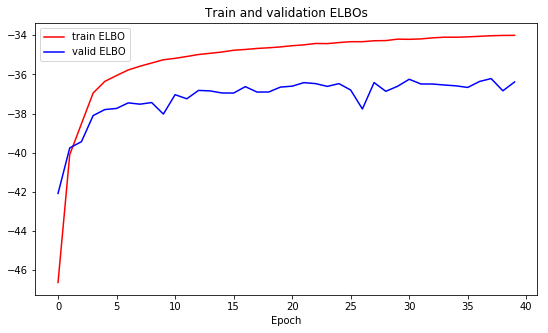

In [0]:
plt.rcParams["figure.figsize"] = [9,5]

plt.figure()
plt.plot(-1 * np.array(vae_trainer.train_losses), 'r', label="train ELBO")
plt.plot(-1 * np.array(vae_trainer.valid_losses), 'b', label="valid ELBO")
plt.title("Train and validation ELBOs")
plt.xlabel("Epoch")
plt.legend()

plt.show()

plt.rcParams["figure.figsize"] = [3,3]

The optimal validation ELBO might not have been reached yet, but we will stick with this amount of training of the VAE for our experiments.

### Save The Model

In [0]:
torch.save(vae_trainer.vae.state_dict(), "weights/VAE_weights_yann_40.pt")

## GAN: WGAN-GP

In this section we implement our Wasserstein GAN with Gradient Policy model.

We start by implementing the generator that has the same architecture as the vae's decoder. The role of the generator is to generate a realistic image from a latent variable randomly sampled in the prior distribution $\mathcal{N}(0,1)$.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        self.main_module = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True), # we use the inplace option to save memory here

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1))

        self.output = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0),100,1,1)
        x = self.main_module(x)
        return self.output(x)

G = Generator()
G = G.to(device)

summary(G,input_size=(100,),batch_size=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [5, 512, 4, 4]         819,712
       BatchNorm2d-2             [5, 512, 4, 4]           1,024
              ReLU-3             [5, 512, 4, 4]               0
   ConvTranspose2d-4             [5, 256, 8, 8]       2,097,408
       BatchNorm2d-5             [5, 256, 8, 8]             512
              ReLU-6             [5, 256, 8, 8]               0
   ConvTranspose2d-7           [5, 128, 16, 16]         524,416
       BatchNorm2d-8           [5, 128, 16, 16]             256
              ReLU-9           [5, 128, 16, 16]               0
  ConvTranspose2d-10             [5, 3, 32, 32]           6,147
          Sigmoid-11             [5, 3, 32, 32]               0
Total params: 3,449,475
Trainable params: 3,449,475
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

We then implement the discriminator. The role of the discriminator is to distinguish between the fake data that have been generated by the generator and the real data sampled from the dataset.

In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.network = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(0.2),

            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ELU(0.2),
        
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0)) # outputs an arbitrary scaled real value


    def forward(self, input_):
        return self.network(input_)

D = Discriminator()
D = D.to(device)
summary(D,input_size=(3, 32, 32),batch_size=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [5, 64, 16, 16]           3,136
       BatchNorm2d-2            [5, 64, 16, 16]             128
               ELU-3            [5, 64, 16, 16]               0
            Conv2d-4             [5, 128, 8, 8]         131,200
       BatchNorm2d-5             [5, 128, 8, 8]             256
               ELU-6             [5, 128, 8, 8]               0
            Conv2d-7             [5, 512, 4, 4]       1,049,088
       BatchNorm2d-8             [5, 512, 4, 4]           1,024
               ELU-9             [5, 512, 4, 4]               0
           Conv2d-10               [5, 1, 1, 1]           8,193
Total params: 1,193,025
Trainable params: 1,193,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 3.75
Params size (MB): 4.55
Estimat

### Class GAN Trainer

In [0]:
class Trainer:
    def __init__(self, G, D, dataloader, batch_size = 32, iterations = 120000, iters_critic = 1, plot_train=False, nb_snap_shots=100, save_snaps=True):
        self.D = D # discriminator
        self.G = G # generator
        self.dataloader = dataloader
        self.batch_size = batch_size
        self.iterations = iterations
        self.iters_critic = iters_critic
        self.G_optimizer = torch.optim.Adam(self.G.parameters(),lr = 1e-4, betas=(0.5, 0.9))
        self.D_optimizer = torch.optim.Adam(self.D.parameters(),lr = 1e-4, betas=(0.5, 0.9))
        self.plot_train = plot_train
        
        self.snap_shots = []
        self.save_snaps=save_snaps # True to save snapshots of generated images during training
        self.iter_snap_shot = self.iterations // nb_snap_shots
        self.lambda_ = 10
        self.latent_dim = 100

        self.gen = iter(self.dataloader)
        self.fixed_noise = torch.randn(16, 100) # 16 latent variables generated randomly
        
        self.D_losses = []
        self.G_losses = []
        self.Grad_hist = []
    
    def generate_batch(self):
        try:
            images,_ = next(self.gen)
        except:
            self.gen = iter(self.dataloader)
            images,_ = next(self.gen)
        return images.to(device)
    
    def gradient_penalty(self,real_data,fake_data,batch_size):
        
        # For each example in the batch, sample 1 point in a uniform distribution [0,1]
        a = torch.rand(batch_size, 1)
        a = a.expand(batch_size, 3*32*32).view(batch_size, 3, 32, 32).to(device)
        
        # Interpolate an image between each fake-real pair in the batch
        interp_image = (a * real_data + (1 - a) * fake_data).requires_grad_(True)
        # Feed this interpolated to the discriminator
        interp_out = self.D(interp_image)
        # Gradient of D(interp_image):
        grads = torch.autograd.grad(interp_out,interp_image,grad_outputs=torch.ones_like(interp_out).to(device),retain_graph=True,create_graph=True,only_inputs=True)
        grads = grads[0].view(grads[0].size(0), -1)
        # (Norm of the gradient -1)²:
        norm_2 = (torch.norm(grads,p=2,dim=1)-1)**2
        # Expectation of norm_2 
        return norm_2.mean()
      
    def critic_one_iteration(self,real_images):
        batch_size = real_images.size(0)
        self.D_optimizer.zero_grad()
        # Expectation of D(real_images):
        D_real_out = D(real_images).mean()
        
        z = torch.randn(batch_size, self.latent_dim).to(device)
        zv = Variable(z, requires_grad=False)
        fake_images = Variable(G(zv).data)
        
        # Expectation of D(fake_images):
        D_fake_out = D(fake_images).mean()
        
        # Gradient penalty
        gradient_penalty = self.gradient_penalty(real_images,fake_images,batch_size)*self.lambda_
        self.Grad_hist.append(gradient_penalty.item())
        
        # Add original critic loss to gradient penalty
        Loss = D_fake_out - D_real_out + gradient_penalty
        self.D_losses.append(Loss.item())
        # Backward
        Loss.backward(retain_graph=True)
        self.D_optimizer.step()

    def generator_one_iteration(self):

        self.G_optimizer.zero_grad()
        # Generate batch size samples from the Normal(0,1) distribution
        z = torch.randn(self.batch_size, self.latent_dim).to(device)
        # Run generator
        zv = Variable(z)
        g_images = G(zv)
        # Run Discriminator on generated images
        D_out = D(g_images)
        # Loss is the expectation of -D_out:
        G_loss = -D_out.mean()
        self.G_losses.append(G_loss.item())
        G_loss.backward()        
        self.G_optimizer.step()

    def run(self):
      
        self.snap_shots = []

        for i in tqdm(range(self.iterations)):
            # allow gradient calculation for D
            for p in self.D.parameters():
                p.requires_grad = True
            
            # gradient descent discriminator (unrolled):
            for k in range(self.iters_critic):
                real_images = self.generate_batch()
                self.critic_one_iteration(real_images)
            
            # disallow gradient calculation for D
            for p in self.D.parameters():
                p.requires_grad = False
            
            # gradient descent generator:
            self.generator_one_iteration()
            
            if i%self.iter_snap_shot==0:
                if(self.plot_train):
                      print(f"Iteration {i}")
                      self.draw_images()
                      plt.show()
                      plt.subplot(2,2,1)
                      plt.plot(self.D_losses)
                      plt.title("D Loss")
                      plt.subplot(2,2,2)
                      plt.plot(self.G_losses)
                      plt.title("G Loss")
                      plt.subplot(2,2,3)
                      plt.plot(self.Grad_hist)
                      plt.title("Gradients")
                      plt.show()
                else:
                      self.snap_shots.append(self.draw_images())
                      #self.snap_shots = np.array(self.snap_shots)
                
    def draw_images(self):
        """
        Generate images
        """
        z_ = self.fixed_noise.to(device)
        gen_image = G(z_).detach().cpu()
        if self.plot_train:
            num = gen_image.size(0)
            plt.rcParams["figure.figsize"] = [10,10]
            n = gen_image.shape[0]
            ax = np.ceil(np.sqrt(num)) 
            ay = np.rint(np.sqrt(num)) 
            fig =plt.figure()
            for i in range(1,num+1):
                sub = fig.add_subplot(ax,ay,i)
                sub.axis('off')
                sub.imshow(gen_image[i-1].transpose(0,2).transpose(0,1))
        else:
            return gen_image

Let us train our model for 100 000 iterations with a batch size of 32:

In [0]:
G = Generator()
G = G.to(device)

D = Discriminator()
D = D.to(device)
trainer = Trainer(G,D,trainloader)

trainer.run()

### Let us get a closer look at what happened during training:

First, let us have a look at the training curves:

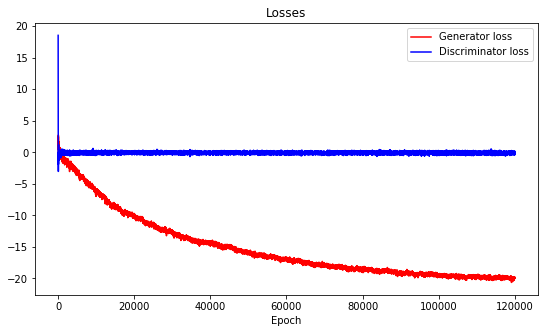

In [0]:
plt.rcParams["figure.figsize"] = [9,5]

plt.figure()
plt.plot(np.array(trainer.G_losses), 'r', label="Generator loss")
plt.plot(np.array(trainer.D_losses), 'b', label="Discriminator loss")
plt.title("Losses")
plt.xlabel("Epoch")
plt.legend()

plt.show()

plt.rcParams["figure.figsize"] = [3,3]

The discriminator loss quickly reaches a value close to zero. We then have $D(x) \sim D (G(z) )$, where $x$ is sampled in the real data and $z$ is sampled in the latent space, meaning that the generator is close to fooling the discriminator during most of the training.

Note that the generator loss is simply the negative expectation of the discriminator's output. Since it is difficult to quantify the generator loss, we have taken snapshots during training. We have captured the output images that were generated from the same latent variable over training to get a visual feedback of the evolution of the generator performance:

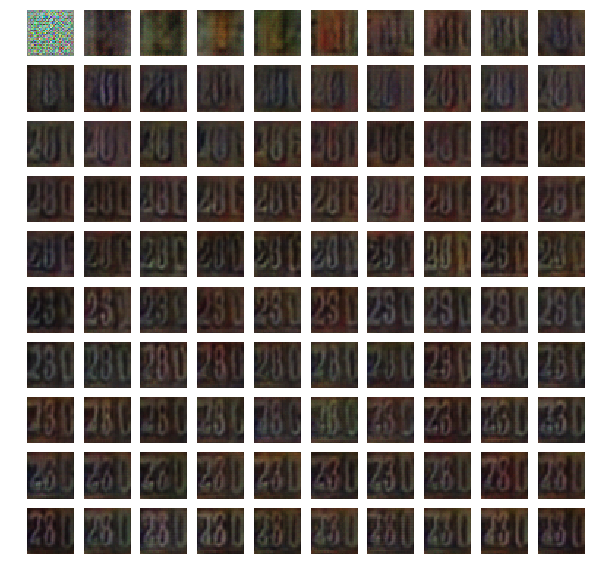

In [0]:
gen_images = trainer.snap_shots
index_latent = 2 # we saved 100 outputs for 16 different latents: select one latent here
snaps = []
for i in range(len(trainer.snap_shots)):
    snaps.append(trainer.snap_shots[i][index_latent])
num = len(snaps)
plt.rcParams["figure.figsize"] = [10,10]
#n = gen_image.shape[0]
ax = np.ceil(np.sqrt(num)) 
ay = np.rint(np.sqrt(num)) 
fig = plt.figure()
for i in range(1,num+1):
    sub = fig.add_subplot(ax,ay,i)
    sub.axis('off')
    sub.imshow(snaps[i-1].transpose(0,2).transpose(0,1))

The first outputs (untrained generator) are blurry in this example, then as the training progresses, the numbers and colors start to stabilize. Interestingly, we notice that even though the general layout stays similar, the generated numbers switch from one to another during training. An even more obvious example is the following:

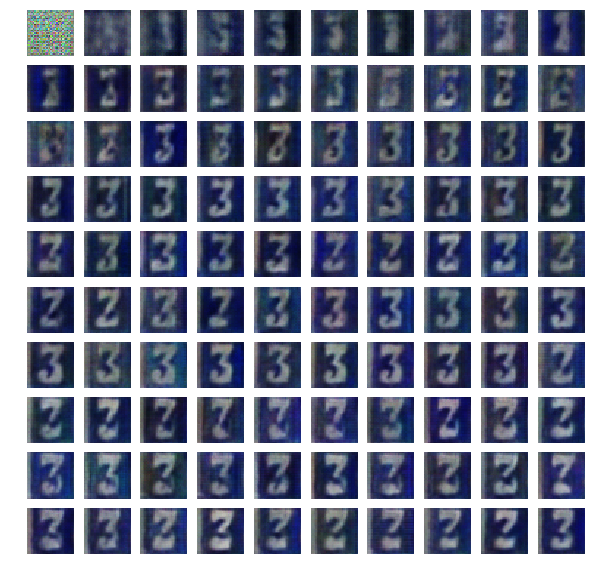

In [0]:
gen_images = trainer.snap_shots
index_latent = 11 # we saved 100 outputs for 16 different latents: select one latent here
snaps = []
for i in range(len(trainer.snap_shots)):
    snaps.append(trainer.snap_shots[i][index_latent])
num = len(snaps)
plt.rcParams["figure.figsize"] = [10,10]
#n = gen_image.shape[0]
ax = np.ceil(np.sqrt(num)) 
ay = np.rint(np.sqrt(num)) 
fig = plt.figure()
for i in range(1,num+1):
    sub = fig.add_subplot(ax,ay,i)
    sub.axis('off')
    sub.imshow(snaps[i-1].transpose(0,2).transpose(0,1))

Clearly, the model didn't reach a solid latent space yet, but we can see it trying. And it is interesting to see that the color stays the same whereas the numbers themselves are not yet completely defined and keep switching from one to another during training. A last example where the latent space seem to have reached a stable state is the following:

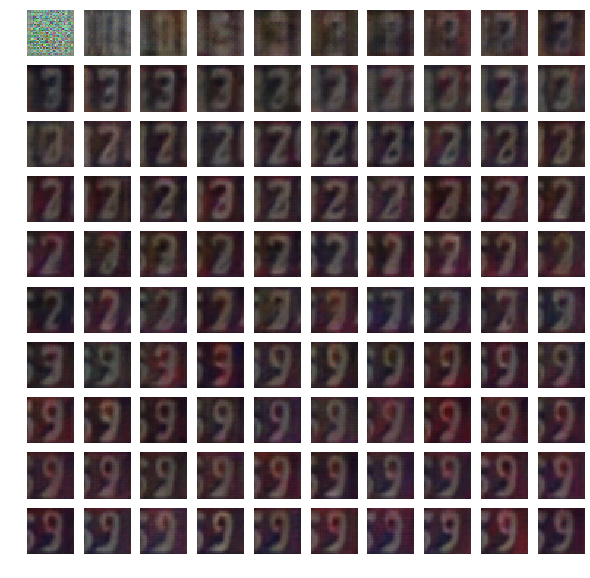

In [0]:
gen_images = trainer.snap_shots
index_latent = 8 # we saved 100 outputs for 16 different latents: select one latent here
snaps = []
for i in range(len(trainer.snap_shots)):
    snaps.append(trainer.snap_shots[i][index_latent])
num = len(snaps)
plt.rcParams["figure.figsize"] = [10,10]
#n = gen_image.shape[0]
ax = np.ceil(np.sqrt(num)) 
ay = np.rint(np.sqrt(num)) 
fig = plt.figure()
for i in range(1,num+1):
    sub = fig.add_subplot(ax,ay,i)
    sub.axis('off')
    sub.imshow(snaps[i-1].transpose(0,2).transpose(0,1))

In this part of the latent space, we see that the model has progressively converged to represent a stable 9, although it was trying to output a 3 or a 2 at the beginning of training. Again, the color stabilizes much quicker than the numbers.

### SAVE The Model

In [0]:
torch.save(trainer.G.state_dict(), "weights/Generator_weights_one_c_k_yann.pt")
torch.save(trainer.D.state_dict(), "weights/Discriminator_weights_one_c_k_yann.pt")

# Qualitative Evaluation
## 1. Visual samples

In [0]:
def draw_images(G,batch_size=64):
    z_ = torch.randn(batch_size,100).to(device)
    gen_image = G(z_).detach().cpu()
    num = gen_image.size(0)
    plt.rcParams["figure.figsize"] = [10,10]
    n = gen_image.shape[0]
    ax = np.ceil(np.sqrt(num)) 
    ay = np.rint(np.sqrt(num)) 
    fig =plt.figure()
    for i in range(1,num+1):
        sub = fig.add_subplot(ax,ay,i)
        sub.axis('off')
        sub.imshow(gen_image[i-1].transpose(0,2).transpose(0,1))

### GAN

In [0]:
wgan_gp = Generator().to(device)

In [0]:
#wgan_gp.load_state_dict(torch.load("./weights/Generator_weights_sigmoid_120k.pt"))
wgan_gp.load_state_dict(torch.load("./weights/Generator_weights_one_c_k_yann.pt"))

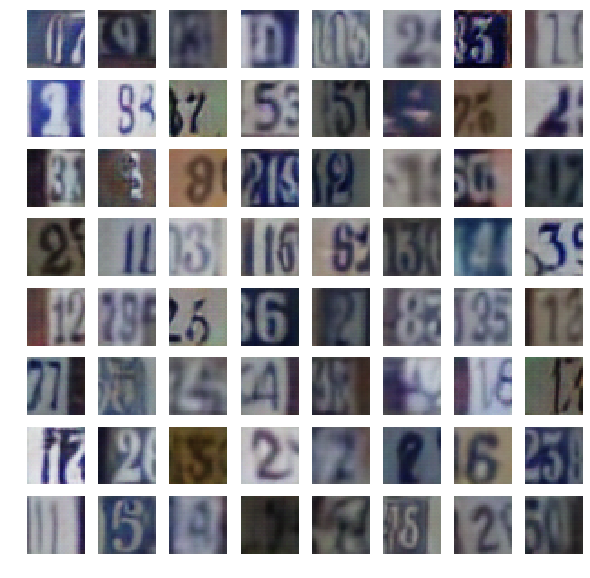

In [0]:
torch.manual_seed(1995)
draw_images(wgan_gp)

### VAE

In [0]:
vae = VAE().to(device)
#vae.load_state_dict(torch.load("./weights/VAE_weights.pt"))
vae.load_state_dict(torch.load("./weights/VAE_weights_yann_40.pt"))

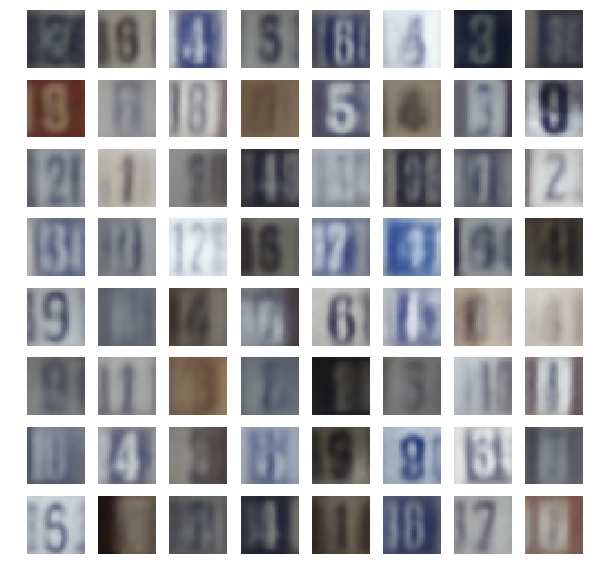

In [0]:
torch.manual_seed(1995)
draw_images(vae.decode)

We notice that if we sample a latent variable randomly, the GAN provides a more realistic output in general. This is explained by the fact that the GAN model is directly trained to generate realistic images from the whole prior distribution, whereas the VAE model is only constrained to have a distribution close to his prior. Therefore the distribution of the clusters created by the VAE in the embedding latent space is close to $\mathcal{N}(0,1)$, but it is not exactly $\mathcal{N}(0,1)$, contrary to the GAN model. 

One way to get closer to the posterior $p_{\theta}(x|z)$ and thus to get better results with the VAE would be to use **Normalizing flows**.




## 2. Exploration of the embedding representation

In [0]:
def stability_one_img(model,n_images=16,seed=42,eps=10):
    torch.manual_seed(seed)
    # Generate random sample of size 100 from the N(0,1) distribution
    random_latent = torch.randn(1,100)
    
    plt.rcParams["figure.figsize"] = [10,10]
    fig = plt.figure()
    
    # Subplots params
    x = torch.sqrt(torch.FloatTensor([n_images])).ceil().item()
    y = n_images//x
        
    for idx in range(n_images):
        if idx == 0:
            title = "Original Image"
            z_ = random_latent
        else:
            # Select a random dimension between 0 (inclusive) & 100 (exclusive)
            selected_idx = torch.randint(0,100,(1,)).item()
            title = f"component {selected_idx}"
            z_ = random_latent
            # Add small perturbation to the selected dimension
            z_[0,selected_idx] += eps
        
        # Apply model on the new latent variables
        gen_image = model(z_.to(device)).detach().cpu()
        
        sub = fig.add_subplot(x,y,idx+1)
        sub.set_title(title)
        sub.imshow(gen_image[0].transpose(0,2).transpose(0,1).numpy())
        sub.axis("off")

### GAN

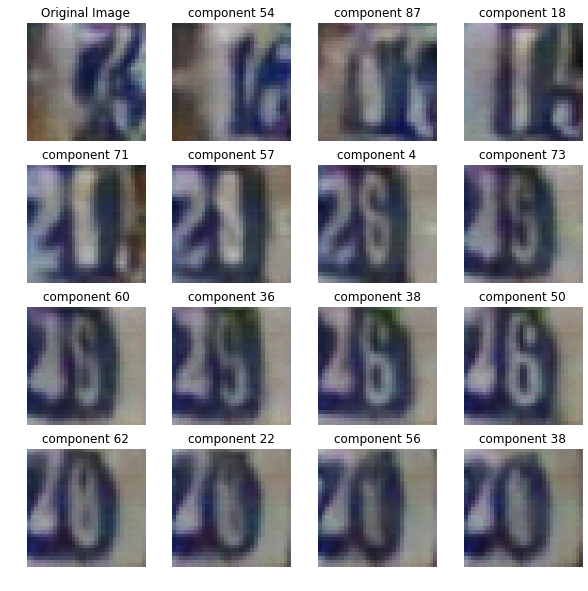

In [0]:
stability_one_img(wgan_gp,n_images=16,seed=6,eps=10)

### VAE

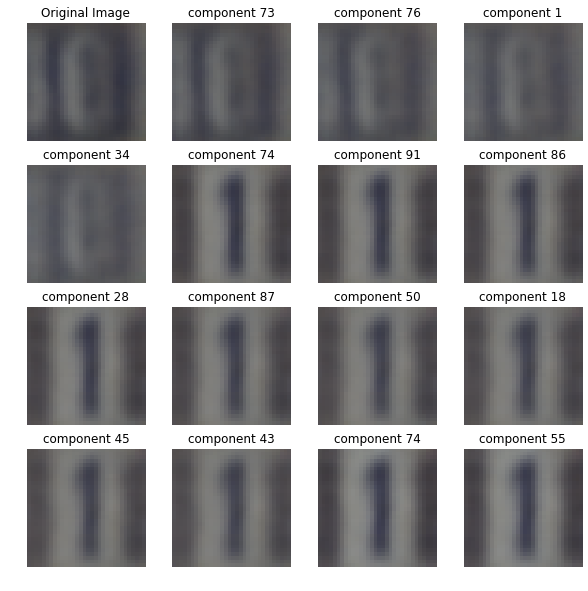

In [0]:
stability_one_img(vae.decode,n_images=16,seed=121,eps=10)

We notice that creating a perturbation in one of many different dimensions often leads to the same cluster. When we arrive in the same cluster as the original one this is not surprising, however we often arrive in another same cluster (for example from 0 to 1 in many different directions). It looks like the clusters are often 'nested' one inside another in the latent space. Also, we notice that the changes operate mainly on the way colors are arranged to form new shapes. In both GAN and VAE, we can see the background and the foreground switching roles in many cases.

We also notice that whereas most of the images generated by the GAN model with the perturbed latent variable are realistic, the VAE model tends to exhibit smooth transitions between one cluster to another, leading to hybrid images that the GAN discriminator would have classified as fake.

## Interpolating in the data space and in the latent space

In [0]:
def interpolate(model,seed=42, nb_outputs=11): # outputs include first and last
  
    # Interpolate in the latent space between z_0 and z_1
    torch.manual_seed(seed)
    z_0 = torch.randn(1,100).to(device)
    z_1 = torch.randn(1,100).to(device)
    
    
    # Interpolate in the data space between x_0 and x_1
    x_0 = model(z_0)
    x_1 = model(z_1)
    
    out_alpha = torch.zeros(nb_outputs, 1 ,x_0.size()[1],x_0.size()[2],x_0.size()[3])
    
    x_alpha = torch.zeros(nb_outputs, 1 ,x_0.size()[1],x_0.size()[2],x_0.size()[3])

    for i in range(nb_outputs):
        alpha = i/(nb_outputs-1)
        z_out = alpha*z_1 + (1-alpha)*z_0
        out_alpha[i] = model(z_out)
        x_alpha[i] = alpha*x_1 + (1-alpha)*x_0
        
    return out_alpha.detach().cpu(), x_alpha.detach().cpu()

def plot_(images):
    fig, axs = plt.subplots(1,images.shape[0], figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    
    for i in range(images.shape[0]):
        axs[i].imshow(images[i,0].transpose(0,2).transpose(0,1))
        axs[i].axis("off")
    plt.plot()

#### GAN

In [0]:
gan_interp_latent, gan_interp_output = interpolate(wgan_gp,seed=1000,nb_outputs=11)

Latent Interpolation


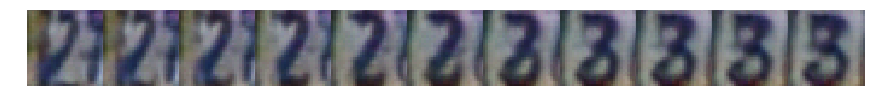

In [0]:
print("Latent Interpolation")
plot_(gan_interp_latent)

Output Interpolation


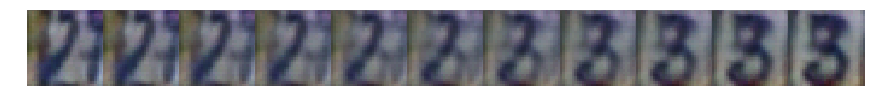

In [0]:
print("Output Interpolation")
plot_(gan_interp_output)

#### VAE

Latent Interpelation


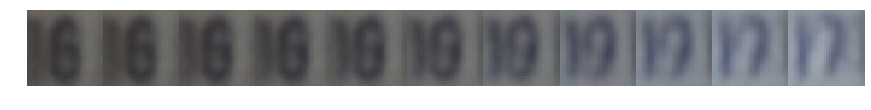

In [0]:
gan_interp_latent, gan_interp_output = interpolate(vae.decode,seed=1053)

print("Latent Interpelation")
plot_(gan_interp_latent)


Output Interpelation


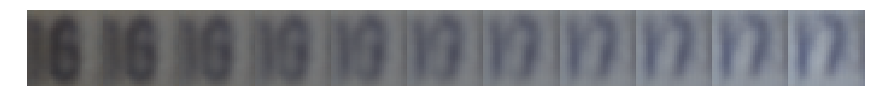

In [0]:
print("Output Interpelation")
plot_(gan_interp_output)

We notice that, when we interpolate between two latent variables in the latent space, the images generated by the GAN model are very different from the images obtained by interpolating in the generated images space (and in particular much more realistic, since the generator would never have generated such images because the discriminator would have classified most of the interpolated output images as fake). Therfore the GAN transition from one cluster to another is sharper.

On the contrary, the interpolation in the latent space of the VAE has an effect which is closer to the interpolation in the output space (indeed, the interpolation in the output space is naturally close to a smooth interpolation, which is what the VAE model creates).

# Quantitative Evaluation


1. We complete the function "calculate_fid_score". The Frechet Inception Distance (FID) score is given by:

$$      d^2((\mu_p, \Sigma_p), (\mu_q, \Sigma_q)) = ||\mu_p - \mu_q||^2_2 + \text{Tr}(\Sigma_p + \Sigma_q - 2(\Sigma_p\Sigma_q)^{1/2}) $$

It is possible that some elements of the diagonal of the matrix $(\Sigma_p\Sigma_q)^{1/2} $ are complex and not real due to numerical instability.


To deal with this problem, we suggest two methods:



* The first one is inspired from the implementation of the FID score in pytorch (https://github.com/bioinf-jku/TTUR/blob/master/fid.py). In fact, if the maximal imaginary part in the diagonal elements of $(\Sigma_p\Sigma_q)^{1/2}$ is smaller than a given threshold (we choose $10^{-5}$ here but the chosen value in the pytorch code is $10^{-3}$), then we can simply keep the real part of those complex elements and get rid of the imaginary part. If the threshold condition is not satisfied, we raise an error that suggests that there might be an error in the FID score calculation.

* The second method is inspired by one of the TAs remark: "as some trick to deal with this. to get the sqrt of A (which can be ill-conditioned due to numerical reason) you can do $(A+\epsilon*I)^{1/2}$ instead, by choosing a small positive epsilon. so once you get the means and covariances you can do the following: let $A=\Sigma_p \Sigma_q$. For a list of choices of epsilon (taken to be close to zero as the limit) evaluate $(A+\epsilon*I)^{1/2}$. The output FID score should be fairly continuous wrt epsilon." Thus, we use a table of values of $\epsilon$ and we calculate the FID score as follows: $$      d^2((\mu_p, \Sigma_p), (\mu_q, \Sigma_q))_\epsilon = ||\mu_p - \mu_q||^2_2 + \text{Tr}(\Sigma_p + \Sigma_q - 2(\Sigma_p\Sigma_q+\epsilon)^{1/2}) $$ and we store the values of $d^2((\mu_p, \Sigma_p), (\mu_q, \Sigma_q))_\epsilon $ that are real.

We return results for both methods to double check the FID score that we obtain.






In [0]:
def calculate_fid_score(sample_feature_iterator,
                        testset_feature_iterator):
    """
    Calculating the Frechet Inception Distance to evaluate the model
    based on stored images.
    
    To avoid having a FID score that has an imaginary part, 
    we use two ways: the first is inspire by the implementation of 
    the FID score in pytorch
    (https://github.com/bioinf-jku/TTUR/blob/master/fid.py).
    This way keeps the real part if the square root if the biggest 
    imaginary component is lower than a given threshold that must be
    low enough. The second approach is to add an epsilon (small enough)
    times the identity matrix to the covariance dot product and look 
    if the FID score is real for a given small epsilon.
    
    """
    print("getting a corrected FID ...")
    
    # retrieving the list of features for all generated images
    sample_array = []
    
    for l in sample_feature_iterator:
      sample_array += [l]
      
    sample_array = np.asarray(sample_array)
    
    # retrieving the list of features extracted from the test set
    test_array = []
    
    for l in testset_feature_iterator:
      test_array += [l]
      
    test_array =  np.asarray(test_array)
    
    # estimating the mean of both distributions
    mean_sample = np.mean(sample_array, axis=0) 
    
    mean_test = np.mean(test_array, axis=0)
    
    # estimating the covariance matrix for both distribtions
    cov_sample = np.cov(sample_array, rowvar=False)
    
    cov_test = np.cov(test_array, rowvar=False)
    
    # Getting the dot product between both covariance matrices
    cov_dot_prod = np.dot(cov_sample, cov_test)
    
    
    # Using a table of values of epsilon to avoid numerical instability
    epsilon = [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14]
    
    print("Using 9 values of epsilon...")
    
    # creating a list for obtained FID scores that are real
    FID_scores = []
    
    for eps in epsilon:
      norm_mean = np.linalg.norm(mean_sample - mean_test)**2
      trace_cov = np.trace(cov_sample + cov_test - 2 * scipy.linalg.sqrtm(cov_dot_prod+eps))
      # getting the FID score
      FID_score = norm_mean + trace_cov
      if not isinstance(FID_score, complex):
        # appending real scores only
        FID_scores.append(round(FID_score,3))
    
    # calculating the square root of the matrix
    sqrt_cov_dot_prod = scipy.linalg.sqrtm(cov_dot_prod)
     
    # checking if sqrt_cov_dot_prod is complex
    if np.iscomplexobj(sqrt_cov_dot_prod):
      if not np.allclose(np.diagonal(sqrt_cov_dot_prod).imag, 0, atol=1e-5):
        m = np.max(np.abs(sqrt_cov_dot_prod.imag))
        raise ValueError(" An imaginary component is higher than the threshold. \
        This might mean that there is an error in the FID score calculation!")
      sqrt_cov_dot_prod = sqrt_cov_dot_prod.real
      
    norm_mean = np.linalg.norm(mean_sample - mean_test)**2
    trace_cov = np.trace(cov_sample + cov_test - 2 * sqrt_cov_dot_prod)
    # getting the FID score
    corrected_FID_score = round(norm_mean + trace_cov,3)
    
    FID_dict = {
      "corrected_FID": corrected_FID_score,
      "FID_added_eps": FID_scores
    }
    
    return FID_dict 

2. We create the function "store_samples" that stores 1000 samples created by the GAN and VAE models in a folder "samples" for each.



In [0]:
def store_samples(model, storage_path, latent_dim = 100, num_samples=1000, seed=1995):
  torch.manual_seed(seed)
  z_ = torch.randn(num_samples,latent_dim).to(device)
  gen_image = model(z_).detach().cpu()
  for i in range(num_samples):
    img = transforms.ToPILImage()(gen_image[i])
    img.save(storage_path+"/sample"+str(i)+".png")
  print("The storage is done.")
    

#### GAN

In [0]:
wgan_gp = Generator().to(device)
wgan_gp.load_state_dict(torch.load("./weights/Generator_weights_one_c_k_yann.pt"))
path_samples_gans = "q3_sampled_images/samples_gans/samples"

store_samples(wgan_gp, path_samples_gans)

The storage is done.


In [0]:
!python score_fid.py "q3_sampled_images/samples_gans"

Test
Using downloaded and verified file: svhn/test_32x32.mat
getting a corrected FID ...
Using 9 values of epsilon...
FID score: {'corrected_FID': 8214.991, 'FID_added_eps': [8214.99]}


#### VAE

In [0]:
vae = VAE().to(device)
vae.load_state_dict(torch.load("./weights/VAE_weights_yann_40.pt"))
path_samples_vae = "q3_sampled_images/samples_vae/samples"

store_samples(vae.decode, path_samples_vae)

The storage is done.


In [0]:
!python score_fid.py "q3_sampled_images/samples_vae"

Test
Using downloaded and verified file: svhn/test_32x32.mat
getting a corrected FID ...
Using 9 values of epsilon...
FID score: {'corrected_FID': 65376.123, 'FID_added_eps': [65376.123, 65376.123]}


**Comparison:**

The FID score for the GAN is: $\sim 8000$, whereas the FID score for the VAE is $\sim 65 000$. The FID score is supposed to compare between the statistics of generated examples and  the examples from the pretrained model on a classification task. As it represents a sort of distance between the two, a lower FID is better and it means more similarity between generated and "test" distributions.


We notice that the FID score that we obtain for the GAN is way better than the one obtained for the VAE. This confirms the observation that we noted from visualising the samples:  the samples generated by the GAN look more realistic, thus are more expected to have closer statictis to the "test" distribution. Also, as we mentioned in the first question, the GAN model is directly trained to generate realistic images from the whole prior distribution, whereas the VAE model is only constrained to have a distribution close to this prior. Thus, when we generate images using the same random noise, the GAN does outperfom the VAE with regard to how close the statistic of the distribution of the generated samples are to the "test" distribution. 


Note that it is recommended that we use a very large number of samples (50k) to get a good estimation of the FID score, otherwise we would overestimate it and it would have high variance (source: https://towardsdatascience.com/graduating-in-gans-going-from-understanding-generative-adversarial-networks-to-running-your-own-39804c283399). This might explain why we obtain these large scores compared to low scores we find in the litterature, even though the generated samples do look realistic for the SVHN dataset, and realism is what the FID score measures.


